In [1]:
# Get a raw data recording, create the stimulus metadata, load all the frames aligned to a stimulus and plot them

# Definitions and functions
%matplotlib inline
from __future__ import division
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import wave
import struct
import h5py
from scipy.io import wavfile
from scipy.signal import spectrogram
import logging
from IPython.display import display
matplotlib.style.use('ggplot')
from ipywidgets import *
import yaml
import numpy.lib.recfunctions as rfn 
import numpy.matlib as npm
import glob
from matplotlib import animation, rc
from IPython.display import HTML

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)


# Check wihic computer to decide where the things are mounted
comp_name=socket.gethostname()
logger.info('Computer: ' + comp_name)
if  'lookfar' in comp_name:
    repos_folder = os.path.abspath('/Users/zeke/reposs')
    experiment_folder = os.path.join(os.path.abspath('/Volumes'), 
                                     'gentner', 
                                     'earneodo', 
                                     'bci_zf')
elif 'passaro' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    cube_experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')
    store_experiment_folder = os.path.join('/Data/bci_zf/')
    experiment_folder = os.path.join('/usr/local/experiment')

sys.path.append(os.path.join(repos_folder, 'soundflow', 'sound_tools'))
sys.path.append(os.path.join(repos_folder, 'ephysflow'))

from basic_viewing import events as evt
# from basic_viewing.structure import kwik_functions as kwkf
# from basic_viewing.structure.core import h5_functions as kwdf

from swissknife.bci.core import kwik_functions as kwkf
from swissknife.bci.core.file import h5_functions as kwdf 
from swissknife.bci.core import expstruct as et
from swissknife.bci import events
from swissknife.h5tools import h5tools as h5
from swissknife.streamtools import streams as st
from swissknife.streamtools import spectral as sp
from swissknife.streamtools import temporal as tp
from swissknife.bci import supersession as ss
from swissknife.bci import stimalign as sa

logger.debug('All modules loaded')

INFO:root:Computer: lookfar
2017-04-18 15:30:07,442 root         INFO     Computer: lookfar


In [2]:
def list_sum(a_list):
    s = a_list[0]
    for new_s in a_list[1:]:
        s+=new_s
    return s


def collect_frames(starts, span, s_f, kwd_file, recs_list, chan_list):
    frames = []
    bad_frames = []
    logger.info('Collecting {} frames...'.format(starts.size))
    for i_start, start in enumerate(starts):
        if i_start % 10 == 0:
            logger.info("Frame {} ...".format(i_start))
        rec = recs_list[i_start]
        try:
            one_frame = st.Chunk(st.H5Data(kwdf.get_data_set(kwd_file, rec),
                                           s_f,
                                           dtype=np.float),
                                 np.array(chan_list),
                                 [start, start + span])
            frames.append(one_frame)
        except AssertionError:
            logger.warning('Frame out of bounds [{0}:{1}]'.format(start, start+span))
            bad_frames.append(i_start)
    return frames, np.delete(starts, bad_frames), np.delete(recs_list, bad_frames)

def identity(x):
    return x

def collect_frames_stream(starts, span, s_f, kwd_file, recs_list, chan_list):
    recs = np.unique(recs_list)
    logger.info('Collecting {} recs...'.format(recs.size))
    all_frames = []
    for i_rec, rec in enumerate(recs):
        logger.info("Rec {} ...".format(rec))
        stream_obj = st.H5Data(kwdf.get_data_set(kwd_file, rec), s_f, dtype=np.float)
        starts_from_rec = stars[recs_list==rec]
        rec_frames = stream_obj.apply_repeated(starts, window, lambda x: x)
        all_frames.append[rec_frames]
    return all_frames

def gather_all_frames(bird, sess_id, viz_set, stim_name='bos_tag', ss_location='ss'):
    exp_pars = et.get_parameters(bird, sess_id, location=ss_location)
    f_n = et.file_names(bird, sess_id)
    f_n_stim = et.file_names(bird, viz_set['stim_sess'])

    stim_id = et.stim_id(exp_pars, stim_name)
    stim_file_path = et.file_path(f_n, ss_location, 'sng')
    with h5py.File(stim_file_path, 'r') as stim_file:
        stim = evt.Song(stim_id, stim_file)    
        starts = stim.get_start()
        recs = stim.get_rec()

    stim_path = os.path.join(f_n_stim['folders']['stim'], 
                      exp_par['search_motiff']['motiff_patterns'][stim_name])
    stim_chunk = st.Chunk(st.WavData2(stim_path))
    
    before = viz_set['before_samp']
    after = viz_set['after_samp']
    with et.open_kwd(bird, sess_id, location=ss_location) as kwd_f:
        v_frames, v_starts, v_recs = collect_frames(starts-before, before+after+stim_chunk.samples, 
                            s_f, 
                            kwd_f, recs, viz_set['channels'])
    
    return v_frames, v_starts, v_recs, stim_chunk

def band_pass_filter(chunk, hp_b, hp_a, lp_b, lp_a):    
    chunk_hi = sg.filtfilt(hp_b, hp_a, chunk)
    chunk_filt = sg.filtfilt(lp_b, lp_a, chunk_hi)
    return chunk_filt

In [3]:
# This should somehow be part of expstruct, maybe
# get the raw parameters and get the config file in the raw file
from swissknife.h5tools import h5tools as h5t
reload(h5t)

def get_all_rec_attribs(bird, sess, location='ss'):
    rec_list = et.get_rec_list(bird, sess, location=location)
    r_attrs = {}
    with et.open_kwd(bird, sess, location=location) as f:
        r_attrs = h5t.group_2_dict({}, f['/recordings'], 'aux')['aux']
    return r_attrs

def get_rec_attribs(bird, sess, rec='0', location='ss'):
    return get_all_rec_attribs(bird, sess, location=location)['{}'.format(rec)]

def get_rec_origin(bird, sess, rec='0', location='ss'):
    rec_attr = get_rec_attribs(bird, sess, rec=rec, location=location)['name'].split(':')
    rec_orig = {} 
    [sess_path, rec_orig['file']] = os.path.split(rec_attr[0])
    rec_orig['sess'] = os.path.split(sess_path)[-1]
    rec_orig['rec'] = rec_attr[1].split('/recordings/')[-1]
    return rec_orig

def get_raw_par(bird, sess, rec='0', location='ss', raw_location='rw'):
    rec_origin = get_rec_origin(bird, sess, rec=rec, location=location)
    return et.get_parameters(bird, rec_origin['sess'], rec=rec, location=raw_location)

def load_site_chan_map(bird, sess, rec='0', location='ss', raw_location='rw'):
    
    rw_par = get_raw_par(bird, sess, rec=rec, location=location, raw_location=raw_location)
    ss_par = et.get_parameters(bird, sess, location=location)
    
    rw_chans = np.array(rw_par['channel_config']['neural'])
    ss_chans = np.array(ss_par['channel_config']['neural'])
    
    probe = et.load_probe(bird, sess, location=location)
    raw_geom = probe['channel_groups'][0]['geometry']
    
    return {ss_ch: raw_geom[rw_chans[ss_ch]] for ss_ch in ss_chans}

def chan_positions(chans, site_map):
    return np.vstack([np.array(site_map[ch]) for ch in chans])

def get_evet(stim_name, bird, sess, ss_location='ss'):
    ex_par = et.get_parameters(bird, sess, location=ss_location)
    st_id = et.stim_id(ex_par, stim_name)
    ev_file_path = et.file_path(et.file_names(bird, sess), ss_location, 'sng')
    ev_file = h5py.File(ev_file_path, 'r')
    return evt.Song(st_id, ev_file)

In [4]:
song_spectr_pars = {'n_window': 512,
                 'n_overlap': 511,
                 'sigma': 30,
                 'f_cut': 10000,
                 'db_cut': 0.000065 }

lfp_filter_band = [1, 1250]

INFO:supersession:Super session path /Users/zeke/bci_zf/tmp_data/z030/day-explore_0/experiment.raw.kwd
2017-04-18 15:30:08,603 supersession INFO     Super session path /Users/zeke/bci_zf/tmp_data/z030/day-explore_0/experiment.raw.kwd
INFO:supersession:searching *_100.raw.kwd
2017-04-18 15:30:08,617 supersession INFO     searching *_100.raw.kwd
INFO:supersession:Making supersession day-explore_0
2017-04-18 15:30:08,629 supersession INFO     Making supersession day-explore_0
INFO:supersession:super file path: /Users/zeke/bci_zf/tmp_data/z030/day-explore_0/experiment.raw.kwd
2017-04-18 15:30:08,630 supersession INFO     super file path: /Users/zeke/bci_zf/tmp_data/z030/day-explore_0/experiment.raw.kwd
INFO:supersession:Found 1 experiment files
2017-04-18 15:30:08,631 supersession INFO     Found 1 experiment files
INFO:supersession:Inserting file /Users/zeke/bci_zf/raw_data/z030/explore_2016-12-16_16-23-43_0/experiment1_100.raw.kwd
2017-04-18 15:30:08,635 supersession INFO     Inserting fi

{'bos_rev_tag': 'bos_rev_tag.wav', 'con_syn_tag': 'bos_syn_tag.wav', 'bos_tag': 'bos_tag.wav'}


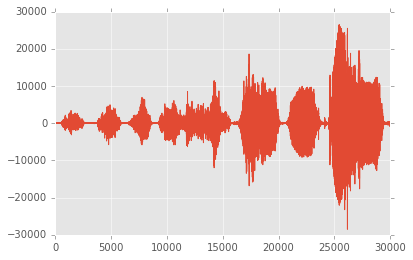

In [5]:
# bird and session
bird_id = 'z030'
sess_day = 'explore'
depth = '0'
raw_location = 'raw'
ss_location = 'tmp'

stim_sess = '001'
super_sess_name = 'day-' + sess_day + '_' + depth
s_l = ss.process_recording_realtime(bird_id, sess_day, depth, raw_location='raw', ss_location='tmp')
sa.align_stim(bird_id, super_sess_name, raw_location='raw', ss_location='tmp')
    
exp_par = et.get_parameters(bird_id, super_sess_name, location=ss_location)
fn = et.file_names(bird_id, super_sess_name)
song_file_path = et.file_path(fn, ss_location, 'sng')
song_file = h5py.File(song_file_path, 'r')

pattern_names = et.get_stims_dict(bird_id, super_sess_name, location=ss_location)

print pattern_names

reload(sp)
#pattern
m_name = 'bos_tag'
m_path = os.path.join(et.file_names(bird_id)['folders']['stim'], stim_sess, 
                      exp_par['search_motiff']['motiff_patterns'][m_name])
m_id = et.stim_id(exp_par, m_name)
m = evt.Song(m_id, song_file)
m_chunk = st.Chunk(st.WavData2(m_path))
#plt.plot(m_chunk.data)
s_f = m_chunk.sound.s_f
lfp_filter_pars = sp.make_butter_bandpass(s_f, lfp_filter_band[0], lfp_filter_band[1])
# spec_obj = sp.Spectrogram(m_chunk.data[:,0], s_f, **song_spectr_pars)
# ax = spec_obj.plot()
plt.plot(m_chunk.data[:, 0])

(<matplotlib.figure.Figure at 0x10b2bb4d0>,
 <matplotlib.axes._axes.Axes at 0x10b29f310>)

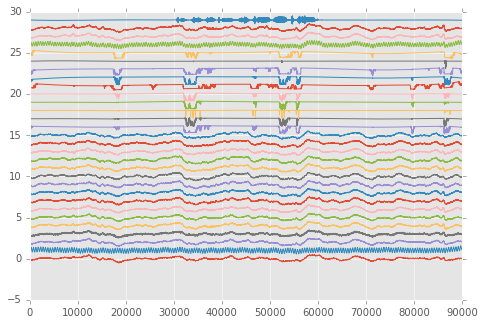

In [6]:
stim_ev = get_evet(m_name, bird_id, super_sess_name, ss_location=ss_location)
starts = stim_ev.get_start()
recs = stim_ev.get_rec()


i_bout = 18
neural_chans = np.array(exp_par['channel_config']['neural'] + [exp_par['channel_config']['mic']])
#neural_chans = np.array(exp_par['channel_config']['neural'])
bad_chans = np.array([0, 25, 31])
neural_chans = np.delete(neural_chans, bad_chans)
good_chans = [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, neural_chans[-1]]
#neural_chans = neural_chans[good_chans]

before = 30000
after = 30000
rec = recs[i_bout]
dset = kwdf.get_data_set(et.open_kwd(bird_id, super_sess_name, location='tmp'), rec)
h5d = st.H5Data(dset, s_f, dtype=np.float)
start = starts[i_bout]

lfp_frame = st.Chunk(h5d, np.array(neural_chans), [start-before, start + m_chunk.samples + after])
lfp_frame.apply_filter(sp.apply_butter_bandpass, lfp_filter_pars)

lfp_frame.plot()

# update neural channels
#exp_par['channel_config']['neural_good']=neural_chans
#et.update_parameters(exp_par, bird, sess)

INFO:root:Collecting 75 frames...
2017-04-18 15:30:36,493 root         INFO     Collecting 75 frames...
INFO:root:Frame 0 ...
2017-04-18 15:30:36,494 root         INFO     Frame 0 ...
INFO:root:Frame 10 ...
2017-04-18 15:30:36,689 root         INFO     Frame 10 ...
INFO:root:Frame 20 ...
2017-04-18 15:30:36,876 root         INFO     Frame 20 ...
INFO:root:Frame 30 ...
2017-04-18 15:30:37,070 root         INFO     Frame 30 ...
INFO:root:Frame 40 ...
2017-04-18 15:30:37,244 root         INFO     Frame 40 ...
INFO:root:Frame 50 ...
2017-04-18 15:30:37,431 root         INFO     Frame 50 ...
INFO:root:Frame 60 ...
2017-04-18 15:30:37,612 root         INFO     Frame 60 ...
INFO:root:Frame 70 ...
2017-04-18 15:30:37,803 root         INFO     Frame 70 ...
2017-04-18 15:30:37,889 root         WARNING  Frame out of bounds [32193022:32252973]


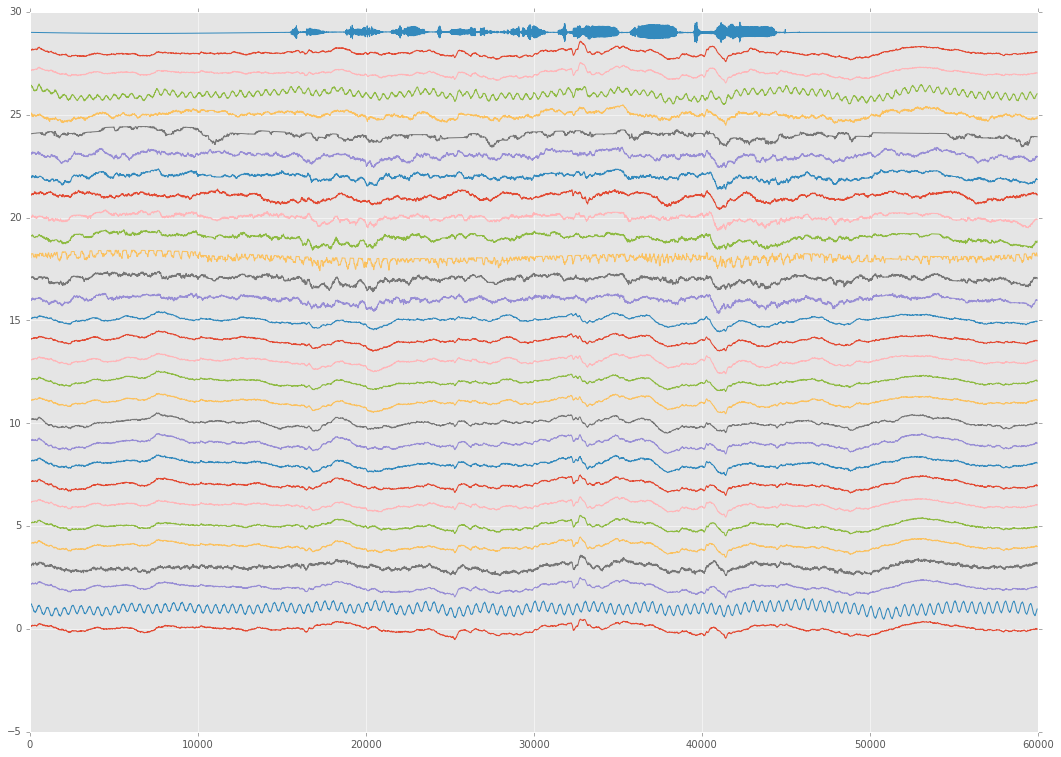

In [7]:
lfp_spectro_pars={'n_window': 256*1,
                  'n_overlap': 256*1-8,
                 'sigma': 30*15*4,
                 'f_cut': 1000,
                 'db_cut': 0.}

viz_set = {'stim_sess': '001', 
          'filter_pars': lfp_filter_pars, 
          'before_samp': 15000,
          'after_samp': 15000,
          'channels': neural_chans,
          'csd': {'steps': 30}
          }


all_frames, all_starts, all_recs, stm_chunk = gather_all_frames(bird_id, super_sess_name, viz_set, 
                                                                stim_name=m_name,
                                                               ss_location=ss_location)
viz_set['stim_chunk'] = stm_chunk
st.list_apply_filter(all_frames, sp.apply_butter_bandpass, lfp_filter_pars)
#st.list_apply_filter(all_frames, st.car, np.arange(neural_chans.size-1))

all_avg = st.sum_frames(all_frames)
st.plot_array(all_avg);
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(14, 10)
# chan = 2
# spec_chan = sp.Spectrogram(all_avg[:,chan], s_f, **lfp_spectro_pars)
# ax=spec_chan.plot(before_ms=2000, log_f=True, cmap='gnuplot2')
# chan = 2
# spec_chan = sp.Spectrogram(all_avg[:,chan], s_f, **lfp_spectro_pars)
# ax=spec_chan.plot(before_ms=2000, log_f=True, cmap='gnuplot2')

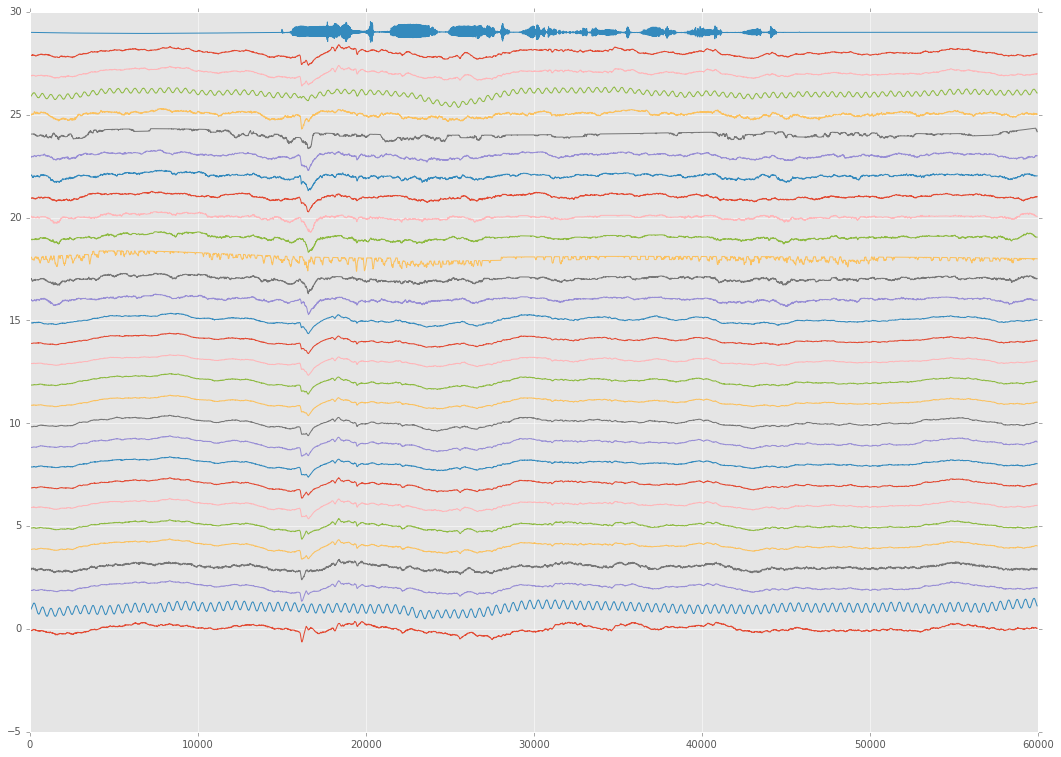

In [24]:
st.plot_array(all_avg);
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(14, 10)

3452.0
fcut_plot 5.70378247466


(<matplotlib.figure.Figure at 0x7fa479e066d0>,
 <matplotlib.axes._axes.Axes at 0x7fa48bc79850>)

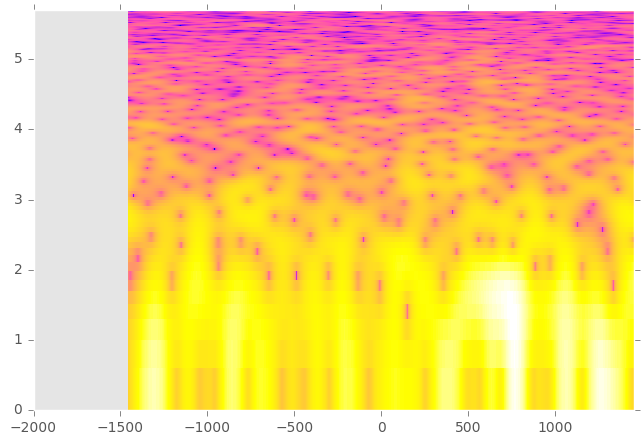

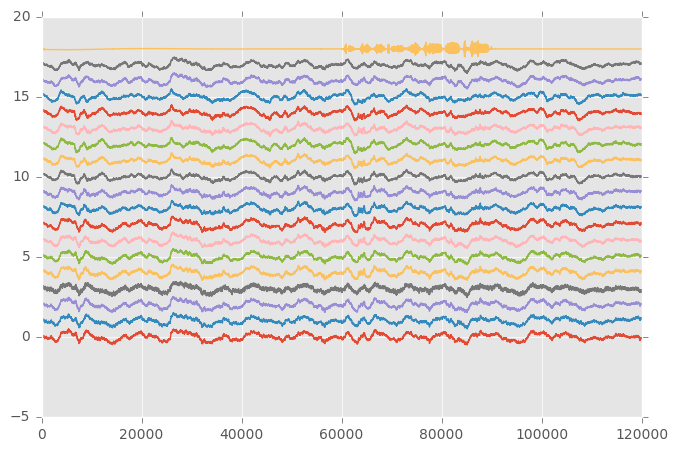

In [99]:
lfp_spectro_pars={'n_window': 4096*8,
                  'n_overlap': 4096*8-8,
                 'sigma': 30*15*4,
                 'f_cut': 300,
                 'db_cut': 0.}

chan = 8
spec_chan = sp.Spectrogram(all_avg[:,chan], s_f, **lfp_spectro_pars)
ax=spec_chan.plot(before_ms=2000, log_f=True, cmap='gnuplot2')
first_avg.plot()

In [31]:
f_cut = 70
n_window = 2048*8
n_overlap = n_window-8

response_spectrogram = spectrogram(first_avg.data[:, 8], s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma*30), 
                                  scaling='spectrum')

plt.pcolormesh(response_spectrogram[1]*s_f, 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(response_spectrogram[2][response_spectrogram[0] < f_cut, :]))

NameError: name 'sigma' is not defined

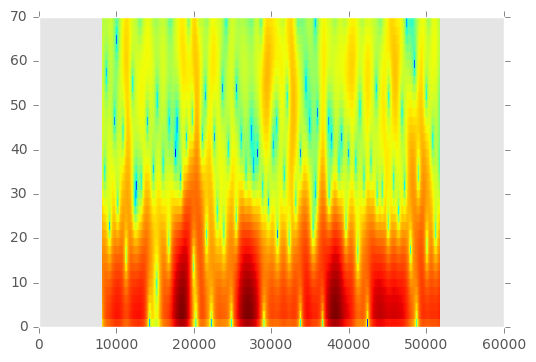

In [14]:
response_spectrogram = spectrogram(lfp_frame.data[:, 6], s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma*15), 
                                  scaling='spectrum')

plt.pcolormesh(response_spectrogram[1]*s_f, 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(response_spectrogram[2][response_spectrogram[0] < f_cut, :]))

In [26]:
# quick confirm of the avg lfp
n_trials = starts.size - 1
n_samples = m_chunk.samples + after + before
n_chans = neural_chans.size

spectr_shape = response_spectrogram[2].shape
n_x = spectr_shape[0]
n_y = spectr_shape[1]

spectr = np.empty([n_trials, n_x, n_y])
lfp = np.empty([n_samples, n_trials, n_chans], dtype=np.float)


spectr_stack = []

for ch in range(n_chans):
    print ch
    for i_trial in range(n_trials):
        start = starts[i_trial]
        one_frame = st.Chunk(h5d, np.array(neural_chans), [start-before, start + m_chunk.samples + after])
        lfp[:, i_trial, :] = one_frame.data
        this_spectrogram = spectrogram(one_frame.data[:, ch], s_f, 
                                      nperseg = n_window, 
                                      noverlap= n_overlap, 
                                      window = sg.gaussian(n_window, sigma*50), 
                                      scaling='density')
        spectr[i_trial, :, :] = (this_spectrogram[2])
    
    spectr_stack.append(spectr)
    
#all_spectra = np.stack(spectr_stack, axis=0)

0
1
2
3
4
5
6
7


MemoryError: 

In [66]:
all_spectra = np.stack(spectr_stack, axis=0)

MemoryError: 

In [52]:
spectr_stack[0].shape

(74, 8193, 3890)

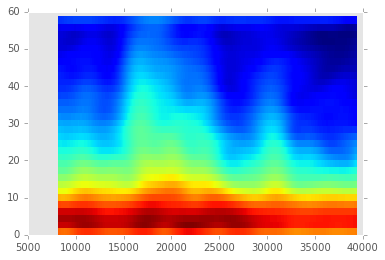

In [28]:
f_cut = 60
ch = 2
mean_spectr = np.mean(spectr_stack[ch], axis=0)
plt.pcolormesh(response_spectrogram[1]*s_f, 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(mean_spectr[:,:][response_spectrogram[0] < f_cut, :]))

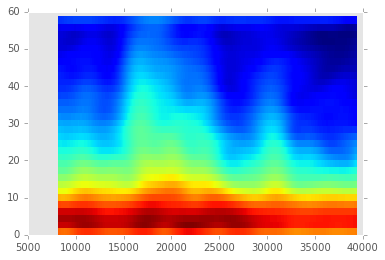

In [34]:
f_cut = 60
ch = 4
mean_spectr = np.mean(spectr_stack[ch], axis=0)
plt.pcolormesh(response_spectrogram[1]*s_f, 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(mean_spectr[:,:][response_spectrogram[0] < f_cut, :]))

In [17]:
plt.figure(1)
plt.subplot(311)
plt.plot(np.mean(lfp[:, :, 1], axis=1))
plt.subplot(312)
plt.pcolormesh(response_spectrogram[1], 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(mean_spectrogram[2][response_spectrogram[0] < f_cut, :]))
plt.subplot(313)
plt.plot(lfp[:,4,0])
plt.show()
fig_name = os.path.join(fn['folders']['ss'], 'spectrum_avg_{}.png'.format(m_name))
plt.savefig(fig_name, format='png')

(49, 2049, 3680)

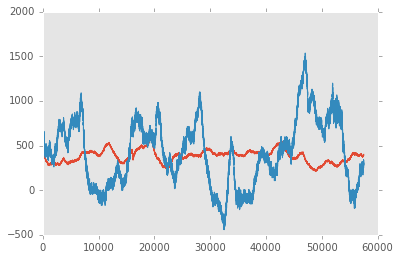

In [82]:
plt.plot(np.mean(lfp[:, :, 1], axis=1))
plt.plot(lfp[:,4,1])

f_cut = 150
n_window = 2048
n_overlap = n_window - 1
response_spectrogram = spectrogram(np.mean(lfp[:, :, 1], axis=1), s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma), 
                                  scaling='spectrum')

plt.pcolormesh(response_spectrogram[1], 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(response_spectrogram[2][response_spectrogram[0] < f_cut, :]))

song_file_path = et.file_path(fn, 'ss', 'sng')
fig_name = os.path.join(fn['folders']['ss'], 'trial_vs_avg_{}.png'.format(m_name))
plt.savefig(fig_name, format='png')

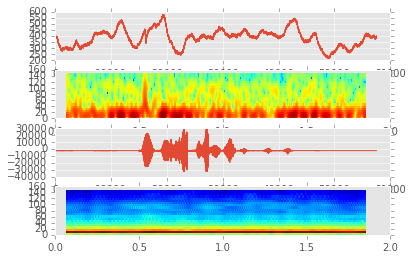

In [83]:
f_cut = 150
n_window = 4096
n_overlap = n_window-8
response_spectrogram = spectrogram(np.mean(lfp[:, :, 1], axis=1), s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma*10), 
                                  scaling='spectrum')
plt.figure(3)
plt.subplot(411)
plt.plot(np.mean(lfp[:, :, 1], axis=1))
plt.subplot(412)
plt.pcolormesh(response_spectrogram[1], 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(response_spectrogram[2][response_spectrogram[0] < f_cut, :]))
plt.subplot(413)
plt.plot(lfp[:,4,0])
plt.subplot(414)
plt.pcolormesh(response_spectrogram[1], 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(mean_spectr[:,:][response_spectrogram[0] < f_cut, :]))
fig_name = os.path.join(fn['folders']['ss'], 'spectrum_avg_{}.png'.format(m_name))
plt.savefig(fig_name, format='png')
plt.show()


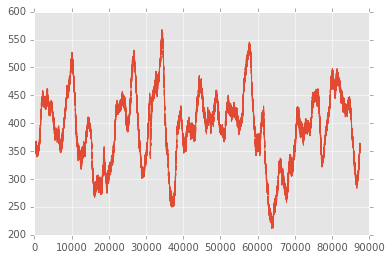

In [96]:
plt.plot(np.mean(lfp[:, :, 1], axis=1))

In [24]:
n_starts = m_starts.size
n_chans = neural_chans.size
n_samples = before + after + m_chunk.samples

sup_lfp = np.empty([n_chans, n_starts, n_samples], dtype=np.float)

for rec in np.unique(recs):
    dset = h5.get_data_set(kwd_file, rec)
    h5d = H5Data(dset, s_f, dtype=np.float)
    this_rec = np.where(recs==rec)[0]
    print this_rec
    for i_trial, start in zip(this_rec, starts[this_rec][:-1]):
        print i_trial
        sup_lfp[:, i_trial, :] = h5d.get_chunk(start-before, start + m_chunk.samples + after, neural_chans).T


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


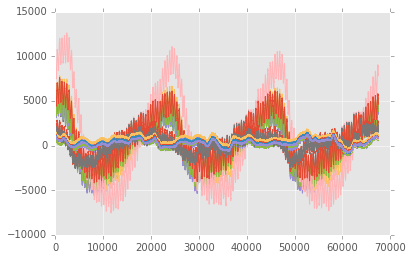

In [10]:
plt.plot(sup_lfp[:,7,:].T)

In [37]:
np.unique(recs)

array([0])

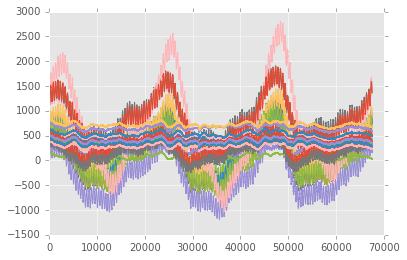

In [11]:
trial_mean = np.mean(sup_lfp, axis=1)
trial_mean.shape
plt.plot(trial_mean.T)

In [15]:
trial_mean = np.mean(sup_lfp, axis=1)
trial_mean.shape

(31, 67535)

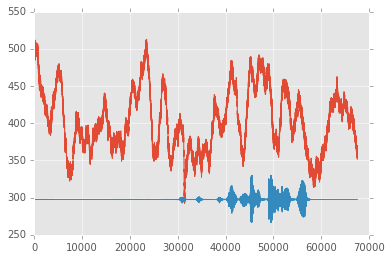

In [38]:
plt.plot(trial_mean[30,:])
plt.plot(lfp_frame.data[:,31]/1000. + 300)

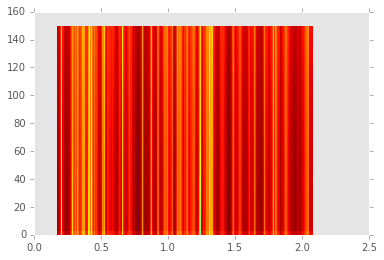

In [46]:
f_cut = 150
n_window = 1024*10
n_overlap = n_window - 1
response_spectrogram = spectrogram(trial_mean[30,:], s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma), 
                                  scaling='spectrum')

plt.pcolormesh(response_spectrogram[1], 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(response_spectrogram[2][response_spectrogram[0] < f_cut, :]))

In [ ]:
scipy.io.wavfile.write(filename, rate, data)

In [49]:
wavfile.write('one_channel.wav', 30000, trial_mean[30,:].astype(np.int16))


In [48]:
pwd

u'/mnt/cube/earneodo/repos/ephysflow'